Module 1: Statistical Efficiency & Downside Risk Analysis Objective: To select assets that maximize the 'Risk-Adjusted Return' based on historical distribution patterns. We prioritize metrics that penalize negative skewness (downside risk) to minimize 'Volatility Drag' on the portfolio's Geometric Mean.

In [5]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('../processed/etf_returns.csv', parse_dates=['Date'])

# Keep only what we need 
df = df[['Date', 'Ticker', 'Daily_Return']].dropna()

# Pivot to have tickers as columns
returns_wide = df.pivot(index='Date', columns='Ticker', values='Daily_Return').sort_index()

print("returns_wide shape:", returns_wide.shape)
print("Date Range:", returns_wide.index.min(), "to", returns_wide.index.max())
returns_wide.head()

returns_wide shape: (3088, 10)
Date Range: 2014-01-03 00:00:00 to 2026-01-23 00:00:00


Ticker,BND,SCHD,SPLV,SPY,VCN.TO,VDY.TO,VFV.TO,VTI,XIC.TO,ZAG.TO
Date,,,,,,,,,,
2014-01-03,0.000125,0.001377,0.000611,-0.000164,-0.002212,0.003349,-0.003174,-0.000210,-0.002796,0.000661
2014-01-06,0.000874,-0.003576,-0.003053,-0.002898,-0.004064,-0.008013,-0.001158,-0.002630,-0.004205,0.000661
2014-01-07,0.001247,0.005522,0.007349,0.006142,0.010015,0.005049,0.018256,0.006434,0.008446,0.002642
2014-01-08,-0.003238,-0.003570,-0.004256,0.000218,0.001469,-0.001340,0.001992,0.000734,0.000931,0.000659
2014-01-09,0.001875,0.001654,0.004274,0.000654,-0.000733,0.004695,0.005112,0.000838,0.000930,-0.000658


In [6]:
TRADING_DAYS = 252

def annualized_return(r):
    r = r.dropna()
    growth  = (1 + r).prod()
    years = len(r) / TRADING_DAYS
    return growth ** (1 / years) - 1

In [7]:
def annualized_volatility(r):
    return r.std(ddof=0) * np.sqrt(TRADING_DAYS)

In [8]:
def sharpe_ratio(r, rf=0):
    excess = r -rf / TRADING_DAYS
    return excess.mean() / excess.std(ddof=0) * np.sqrt(TRADING_DAYS)

In [9]:
def sortino_ratio(r, mar=0.0):
    downside = r[r < mar]
    downside_dev = downside.std(ddof=0) * np.sqrt(TRADING_DAYS)
    return (r.mean() * TRADING_DAYS) / downside_dev if downside_dev != 0 else np.nan

# Why this matters (key talking point):
# Penalizes only harmful volatility
# Aligns with your Defensive Growth mandate
# Replaces “psychological” metrics with math

In [10]:
def max_drawdown(r):
    cumulative = (1 + r).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown.min()

#Why: This is the worst-case investor experience.

In [11]:
def ulcer_index(r):
     r = r.dropna()
     if len(r) < 2:
        return np.nan
     eq = (1 + r).cumprod()
     peak = eq.cummax()
     dd_pct = (eq / peak - 1) * 100.0
     return np.sqrt(np.mean(dd_pct**2))

# Why this is powerful:
# Two ETFs can have the same max drawdown
# The one that stays underwater longer is worse
# Ulcer Index captures that better than volatility

In [14]:
candidates = ["SPY","SCHD","USMV","QUAL","MOAT","VDY.TO","ZLB.TO","BND","ZAG.TO","GLD","IAU"]
candidates = [c for c in candidates if c in returns_wide.columns]

# candidates under consideration.

In [15]:
rows = []
for t in candidates:
    r = returns_wide[t].dropna()
    rows.append({
        "ETF": t,
        "Annualized Return": annualized_return(r),
        "Sharpe": sharpe_ratio(r),
        "Sortino": sortino_ratio(r),
        "Max Drawdown": max_drawdown(r),
        "Ulcer Index": ulcer_index(r),
    })

metrics_df = pd.DataFrame(rows).set_index("ETF")

# Efficiency Score = Return per unit of pain (Ulcer)
metrics_df["Efficiency Score"] = metrics_df["Annualized Return"] / metrics_df["Ulcer Index"]

ranked = metrics_df.sort_values("Efficiency Score", ascending=False)
ranked

,Annualized Return,Sharpe,Sortino,Max Drawdown,Ulcer Index,Efficiency Score
ETF,,,,,,
SPY,0.135765,0.822476,0.999012,-0.337173,6.697622,0.020271
SCHD,0.111250,0.734938,0.926561,-0.333671,5.529987,0.020118
VDY.TO,0.107903,0.732919,0.826980,-0.392112,7.618881,0.014163
ZAG.TO,0.024760,0.400406,0.449090,-0.180332,6.356707,0.003895
BND,0.022333,0.452190,0.566563,-0.185822,6.372164,0.003505


In [16]:
equity_list = ["SPY","SCHD","USMV","QUAL","MOAT","VDY.TO","ZLB.TO"]
hedge_bond_list = ["IAU","GLD","BND","ZAG.TO"]

equity_list = [t for t in equity_list if t in ranked.index]
hedge_bond_list = [t for t in hedge_bond_list if t in ranked.index]

top_2_equity = ranked.loc[equity_list].head(2)
top_1_hedge_bond = ranked.loc[hedge_bond_list].head(1)

print("Top 2 Equity ETFs (Pain-Adjusted):")
display(top_2_equity)

print("Top 1 Hedge/Bond ETF (Pain-Adjusted):")
display(top_1_hedge_bond)

Top 2 Equity ETFs (Pain-Adjusted):


,Annualized Return,Sharpe,Sortino,Max Drawdown,Ulcer Index,Efficiency Score
ETF,,,,,,
SPY,0.135765,0.822476,0.999012,-0.337173,6.697622,0.020271
SCHD,0.111250,0.734938,0.926561,-0.333671,5.529987,0.020118


Top 1 Hedge/Bond ETF (Pain-Adjusted):


,Annualized Return,Sharpe,Sortino,Max Drawdown,Ulcer Index,Efficiency Score
ETF,,,,,,
BND,0.022333,0.45219,0.566563,-0.185822,6.372164,0.003505


In [17]:
equity_candidates = ["SPY", "SCHD", "USMV", "QUAL", "MOAT", "VDY.TO", "ZLB.TO"]
hedge_candidates = ["BND", "ZAG.TO", "GLD", "IAU"]

equity_candidates = [t for t in equity_candidates if t in returns_wide.columns]
hedge_candidates = [t for t in hedge_candidates if t in returns_wide.columns]

winners = ["SPY", "SCHD", "BND"]
winners = [t for t in winners if t in returns_wide.columns]

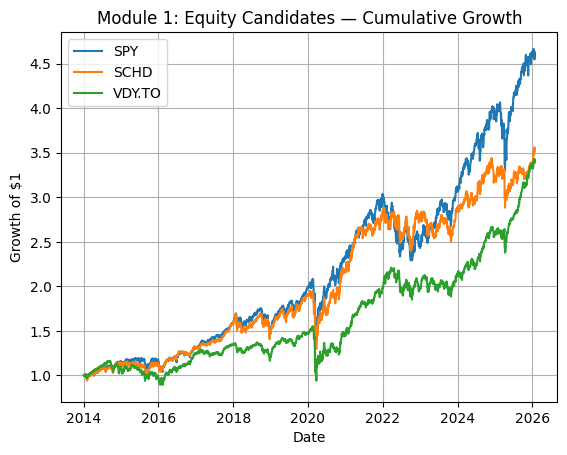

In [19]:
def equity_curve(r):
    return (1 + r.fillna(0)).cumprod()

plt.figure()
for t in equity_candidates:
    plt.plot(equity_curve(returns_wide[t]), label=t)

plt.title("Module 1: Equity Candidates — Cumulative Growth")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.show()

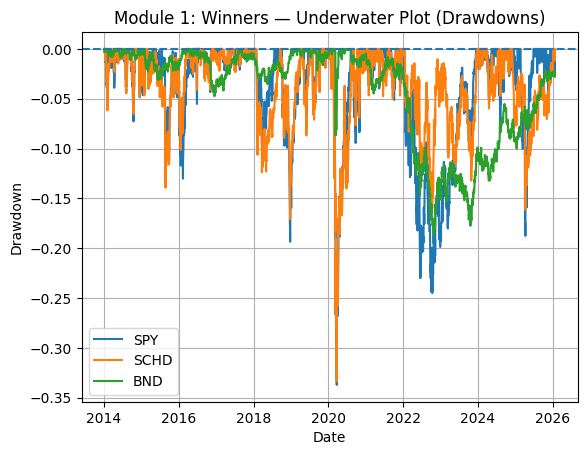

In [20]:
def drawdown_series(r):
    eq = (1 + r.fillna(0)).cumprod()
    peak = eq.cummax()
    return (eq / peak - 1)

plt.figure()
for t in winners:
    plt.plot(drawdown_series(returns_wide[t]), label=t)

plt.axhline(0, linestyle="--")
plt.title("Module 1: Winners — Underwater Plot (Drawdowns)")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.legend()
plt.grid(True)
plt.show()


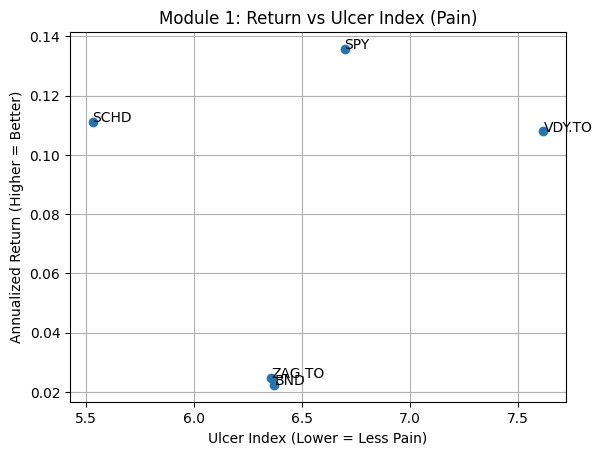

In [21]:
plt.figure()
x = metrics_df["Ulcer Index"]
y = metrics_df["Annualized Return"]

plt.scatter(x, y)

for etf in metrics_df.index:
    plt.text(x.loc[etf], y.loc[etf], etf)

plt.title("Module 1: Return vs Ulcer Index (Pain)")
plt.xlabel("Ulcer Index (Lower = Less Pain)")
plt.ylabel("Annualized Return (Higher = Better)")
plt.grid(True)
plt.show()